# Notebook Lineare Modelle:

### Gliederung: 
1. Tests bezüglich Testgröße
2. Multivariante Lineare Regression
1. Fazit und validierung der Linearen Modelle
3. (Versuch) Polynomiale Regression


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

cwd = str(Path.cwd())

X = pd.read_csv(cwd + "/../data/Featchers_sorted.csv")
Y = pd.read_csv(cwd + "/../data/Goals_sorted.csv")

### Verschiedene Analysen zur test_size

In [2]:
num_iterations = 10
lag_values = [1, 2, 3]
target_variables = ['LUFTTEMPERATUR', 'NIEDERSCHLAGSHOEHE']
test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5]

# Liste für die iterierten Ergebnisse
iterated_results = []

for iteration in range(num_iterations):
    # Leere Dictionarys für die iterierten MSE- und R2-Werte
    iterated_mse_values = {'train': {'LUFTTEMPERATUR': [], 'NIEDERSCHLAGSHOEHE': []}, 'test': {'LUFTTEMPERATUR': [], 'NIEDERSCHLAGSHOEHE': []}}
    iterated_r2_values = {'train': {'LUFTTEMPERATUR': [], 'NIEDERSCHLAGSHOEHE': []}, 'test': {'LUFTTEMPERATUR': [], 'NIEDERSCHLAGSHOEHE': []}}

    for lag in lag_values:
        for target in target_variables:
            y = Y[f'straubing_{target}_future_{lag}Day']
            for test_size in test_sizes:
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

                model = LinearRegression()
                model.fit(X_train, y_train)

                y_train_pred = model.predict(X_train)
                y_test_pred = model.predict(X_test)

                mse_train = mean_squared_error(y_train, y_train_pred)
                mse_test = mean_squared_error(y_test, y_test_pred)
                r2_train = r2_score(y_train, y_train_pred)
                r2_test = r2_score(y_test, y_test_pred)

                iterated_mse_values['train'][target].append(mse_train)
                iterated_mse_values['test'][target].append(mse_test)
                iterated_r2_values['train'][target].append(r2_train)
                iterated_r2_values['test'][target].append(r2_test)

                result = {
                    'iteration': iteration,
                    'lag': lag,
                    'target': target,
                    'test_size': test_size,
                    'mse_train': mse_train,
                    'mse_test': mse_test,
                    'r2_train': r2_train,
                    'r2_test': r2_test
                }

                iterated_results.append(result)

#print(iterated_results)

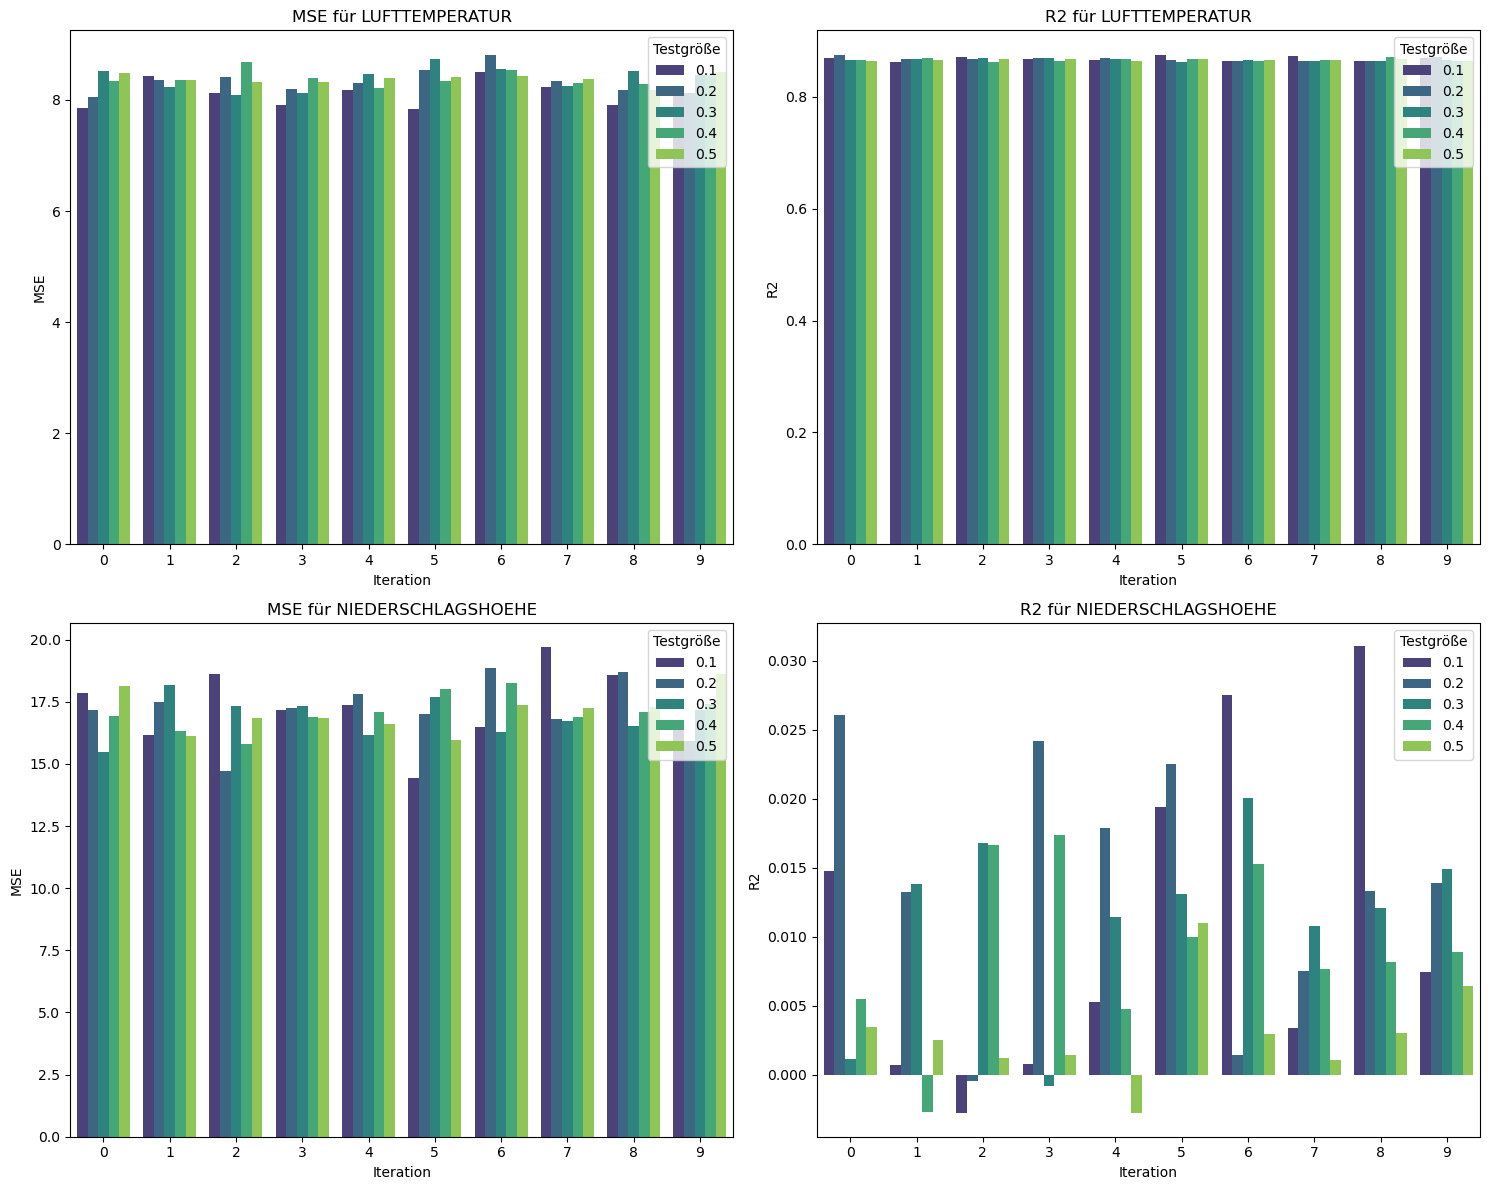

In [3]:
df_iterated_results=pd.DataFrame(iterated_results) #weiterverwendung leichter als data frame

# Aufteilen in Niederschlag und Temperatur
df_temp = df_iterated_results[df_iterated_results['target'] == 'LUFTTEMPERATUR']
df_nied = df_iterated_results[df_iterated_results['target'] == 'NIEDERSCHLAGSHOEHE']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

# Plot für MSE bei Temperatur
sns.barplot(x='iteration', y='mse_test', hue='test_size', data=df_temp, errorbar=None, palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('MSE für LUFTTEMPERATUR')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].legend(title='Testgröße')

# Plot für R2 bei Temperatur
sns.barplot(x='iteration', y='r2_test', hue='test_size', data=df_temp, errorbar=None, palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('R2 für LUFTTEMPERATUR')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('R2')
axes[0, 1].legend(title='Testgröße')

# Plot für MSE bei Niederschlag
sns.barplot(x='iteration', y='mse_test', hue='test_size', data=df_nied, errorbar=None, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('MSE für NIEDERSCHLAGSHOEHE')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].legend(title='Testgröße')

# Plot für R2 bei Niederschlag
sns.barplot(x='iteration', y='r2_test', hue='test_size', data=df_nied, errorbar=None, palette='viridis', ax=axes[1, 1])
axes[1, 1].set_title('R2 für NIEDERSCHLAGSHOEHE')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('R2')
axes[1, 1].legend(title='Testgröße')

plt.tight_layout()
plt.savefig('test_sizes_mse.png')
plt.show()

Auch über merhere Ausführungen ist hierbei keine klare Tendenz bezüglich test size erkennbar.

In [4]:
#zusammenfassen von Werten die für die Aussage unwichtig sind
newdf = df_iterated_results.groupby(['test_size', 'target']).agg({'mse_test': 'mean'})
newdf = newdf.rename(columns={'mse_test': 'mse_avg'})
best_test_size = min(newdf['mse_avg'].items(), key=lambda x: x[1])[0][0] #anzahl wie oft mse bei test size am besten war entscheidend, kein mean best mse
print(newdf)
print(f'die beste test size über {num_iterations} iterationen war {best_test_size}')

                                mse_avg
test_size target                       
0.1       LUFTTEMPERATUR       8.121740
          NIEDERSCHLAGSHOEHE  17.283039
0.2       LUFTTEMPERATUR       8.329376
          NIEDERSCHLAGSHOEHE  17.169216
0.3       LUFTTEMPERATUR       8.393915
          NIEDERSCHLAGSHOEHE  16.881715
0.4       LUFTTEMPERATUR       8.390820
          NIEDERSCHLAGSHOEHE  17.065997
0.5       LUFTTEMPERATUR       8.380627
          NIEDERSCHLAGSHOEHE  17.100376
die beste test size über 10 iterationen war 0.1


Wie oben im Boxplot zu erkennen ist, macht das variieren der test size keinen unterschied. Im folgenden wird trotzdem der Wert von best_test_size verwendet.

## Multivariate Lineare Regression
Hier wird die oben berechnete Test size verwendet und das Modell auf basis der daraus erhaltenen Ergebnisse ein letztes mal trainiert und kurz validiert

In [9]:
models = {}

for lag in lag_values:
    for target in target_variables:
        y = Y[f'straubing_{target.upper()}_future_{lag}Day']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        models[f'model_lag{lag}_{target}'] = model

        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)

        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)

        print(f'Tag {lag} {target}:')
        print(f'MSE Train ={mse_train:.4f}\tRMSE Train={np.sqrt(mse_train):.4f}')
        print(f'MSE Test ={mse_test:.4f}\tRMSE Test={np.sqrt(mse_test):.4f}')
        print(f'R2 Train={r2_train:.4f}\t\tR2 Test={r2_test:.4f}\n')

Tag 1 LUFTTEMPERATUR:
MSE Train =3.9654	RMSE Train=1.9913
MSE Test =3.9399	RMSE Test=1.9849
R2 Train=0.9359		R2 Test=0.9409

Tag 1 NIEDERSCHLAGSHOEHE:
MSE Train =16.1273	RMSE Train=4.0159
MSE Test =14.2639	RMSE Test=3.7768
R2 Train=0.0890		R2 Test=0.0370

Tag 2 LUFTTEMPERATUR:
MSE Train =8.6378	RMSE Train=2.9390
MSE Test =8.3763	RMSE Test=2.8942
R2 Train=0.8638		R2 Test=0.8617

Tag 2 NIEDERSCHLAGSHOEHE:
MSE Train =15.5410	RMSE Train=3.9422
MSE Test =20.9608	RMSE Test=4.5783
R2 Train=0.0370		R2 Test=0.0061

Tag 3 LUFTTEMPERATUR:
MSE Train =11.5321	RMSE Train=3.3959
MSE Test =11.7758	RMSE Test=3.4316
R2 Train=0.8155		R2 Test=0.8162

Tag 3 NIEDERSCHLAGSHOEHE:
MSE Train =15.1129	RMSE Train=3.8875
MSE Test =23.4594	RMSE Test=4.8435
R2 Train=0.0343		R2 Test=-0.0132



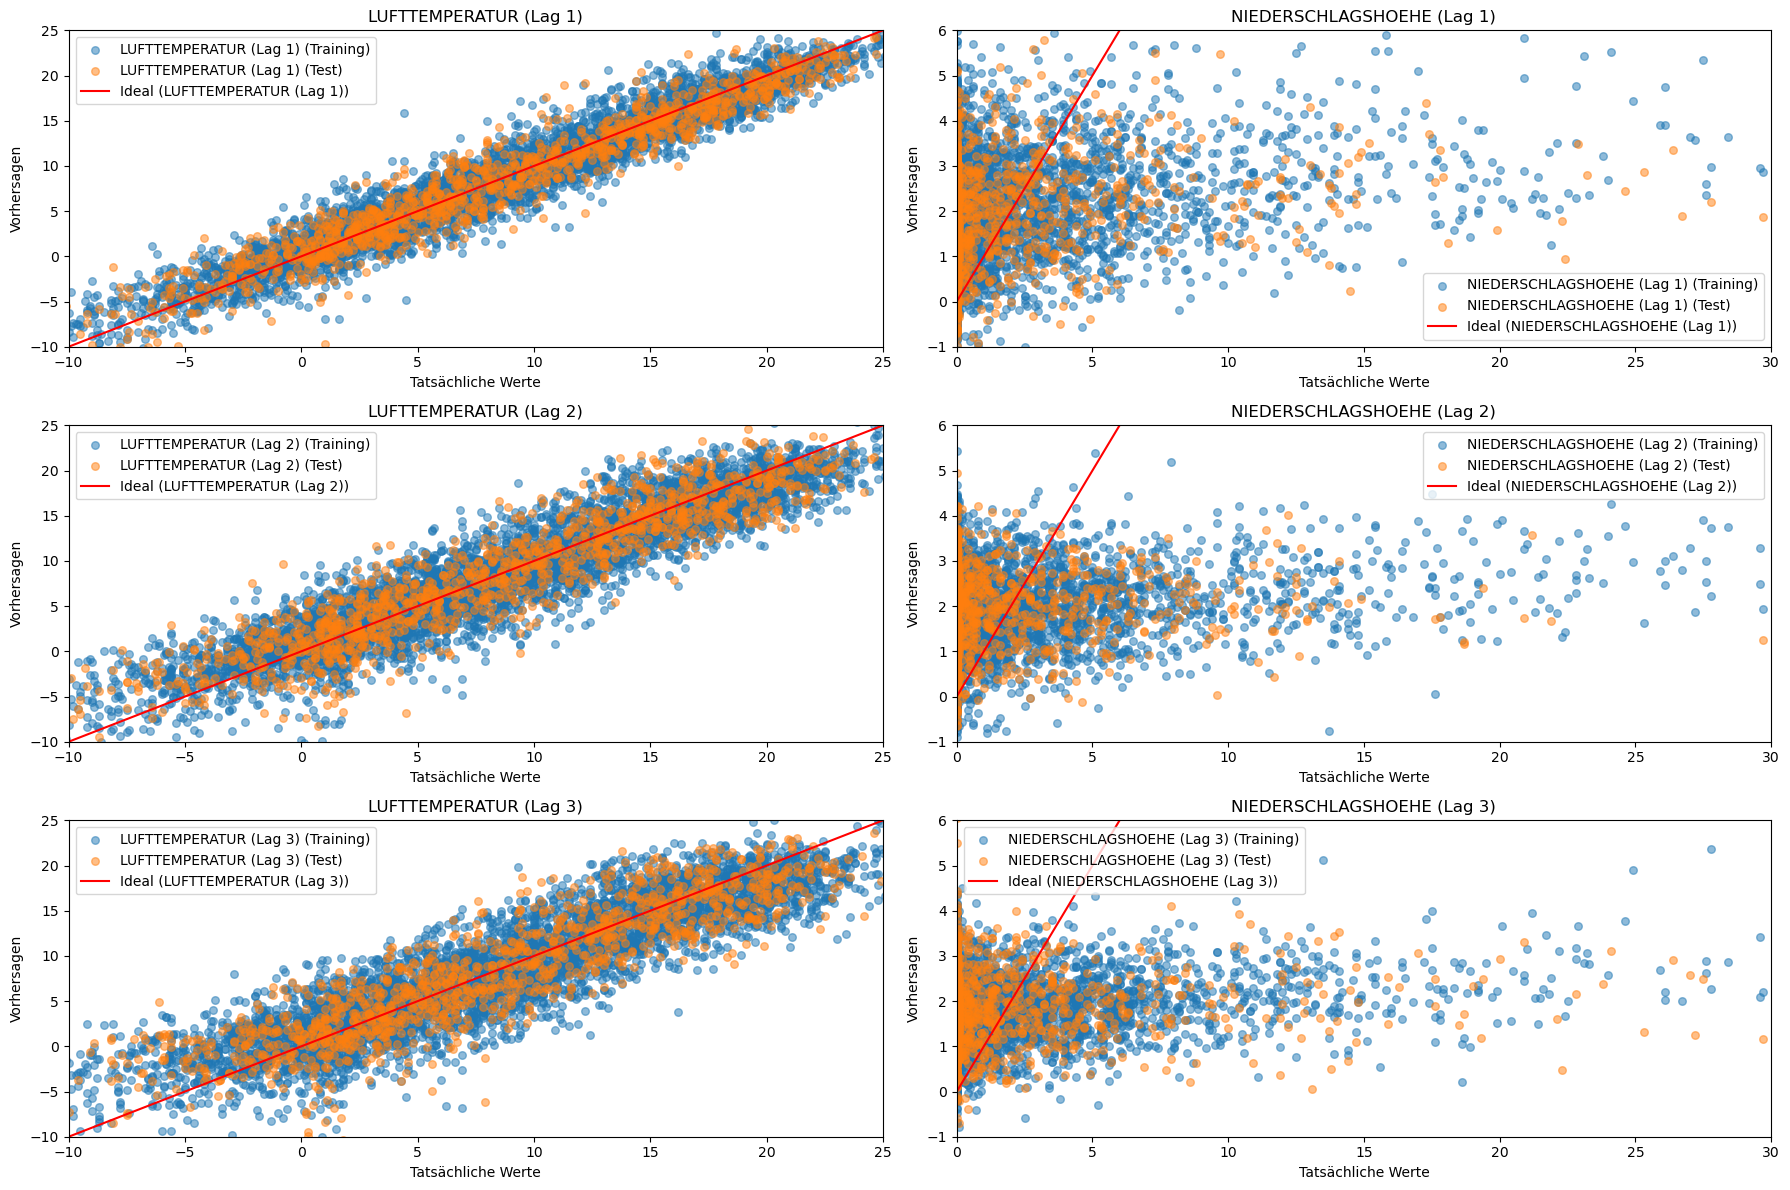

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def plot_deviation(ax, X, y, target_name):
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    if 'NIEDERSCHLAGSHOEHE' in target_name:
        #andere Maße für Niederschlag
        xlim = (0, 30)
        ylim = (-1, 6)
    else:
        xlim = (-10, 25)
        ylim = (-10, 25)

    ax.scatter(y_train, y_train_pred, label=f'{target_name} (Training)', alpha=0.5, s=30)
    ax.scatter(y_test, y_test_pred, label=f'{target_name} (Test)', alpha=0.5, s=30)
    ax.plot(xlim, xlim, linestyle='-', color='red', label=f'Ideal ({target_name})')
   
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
 
    ax.set_xlabel('Tatsächliche Werte')
    ax.set_ylabel('Vorhersagen')
    ax.set_title(target_name)
    ax.legend()

fig, axs = plt.subplots(len(lag_values), len(target_variables), figsize=(18, 12))

for i, lag in enumerate(lag_values):
    for j, target in enumerate(target_variables):
        y = Y[f'straubing_{target.upper()}_future_{lag}Day']
        plot_deviation(axs[i, j], X, y, f'{target} (Lag {lag})')

plt.tight_layout()
plt.savefig('pred_vs_actual.png')
plt.show()

# Validierung 
## Temperatur
Linearer Zusammenhang deutlich erkennbar, Modell also grundsätzlich korrekt.
Deutlich: Für kurzfristigere vorhersage weniger abweichung vom echten Wert, r2 score lässt erkennen das lineare Korelation definitiv vorhanden ist.

## Niederschlag
Vorhersage schwankt um Wert 2.
Modell unbrauchbar, da kein Linearer Zusammenhang zwischen den Features (systematischer Fehler siehe r2 score nahe an 0) vor 3 Tagen und dem Niederschlag heute besteht. Time Lag zu groß, daher keine Korelation, selbst bei 1tägiger Vorhersage

## Polynomiale Regression (nicht fertiggestellt)
Aufgrund fehlender Zeit (und RAM) konnten wir die Polynomiale Regression nicht fertigstellen. Der Grund warum wir unseren Fokus auf die andern Modelle gelegt haben war der Folgende:

- Von der Polynomialen Regression haben wir uns aufgrund der guten darstellung durch die Lineare regression bei der Temperatur keine guten werte erhofft (massives overfitting, das auch schon bei grad 2 tatsächlich zu sehen war)
- Da Niederschlagshöhe eher einen sporadischen Verlauf annimmt haben wir uns auch hier keine Verbesserung erhofft.

Zukunftsausblick: Overfitting würde sich eventuell durch L1-/L2 Regularisierung vermeiden lassen

In [7]:
for lag in lag_values:
    for target in target_variables:
        y = Y[f'straubing_{target.upper()}_future_{lag}Day']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

        # Polynomiale Regression
        poly_features = PolynomialFeatures(degree=2)  #Grad des Polynoms wählen
        X_train_poly = poly_features.fit_transform(X_train)
        X_test_poly = poly_features.transform(X_test)

        poly_model = LinearRegression()
        poly_model.fit(X_train_poly, y_train)

        y_train_pred_poly = poly_model.predict(X_train_poly)
        y_test_pred_poly = poly_model.predict(X_test_poly)

        mse_train_poly = mean_squared_error(y_train, y_train_pred_poly)
        mse_test_poly = mean_squared_error(y_test, y_test_pred_poly)

        r2_train_poly = r2_score(y_train, y_train_pred_poly)
        r2_test_poly = r2_score(y_test, y_test_pred_poly)

        # Ausgabe der polynomiellen Regression
        print(f'Tag {lag} {target} (Polynomiale Regression):')
        print(f'MSE Train={mse_train_poly:.4f}\tRMSE Train={np.sqrt(mse_train_poly):.4f}')
        print(f'MSE Test={mse_test_poly:.4f}\tRMSE Test={np.sqrt(mse_test_poly):.4f}')
        print(f'R2 Train={r2_train_poly:.4f}\tR2 Test={r2_test_poly:.4f}\n')

        # Speichern des polynomiellen Modells
        models[f'poly_model_lag{lag}_{target}'] = poly_model

Tag 1 LUFTTEMPERATUR (Polynomiale Regression):
MSE Train=0.4863	RMSE Train=0.6974
MSE Test=432.8964	RMSE Test=20.8062
R2 Train=0.9922	R2 Test=-5.5941

Tag 1 NIEDERSCHLAGSHOEHE (Polynomiale Regression):
MSE Train=2.6116	RMSE Train=1.6161
MSE Test=2302.2280	RMSE Test=47.9815
R2 Train=0.8496	R2 Test=-141.2510

Tag 2 LUFTTEMPERATUR (Polynomiale Regression):
MSE Train=1.0721	RMSE Train=1.0354
MSE Test=559.6989	RMSE Test=23.6580
R2 Train=0.9831	R2 Test=-8.2661

Tag 2 NIEDERSCHLAGSHOEHE (Polynomiale Regression):
MSE Train=3.2802	RMSE Train=1.8111
MSE Test=2037.1300	RMSE Test=45.1346
R2 Train=0.8174	R2 Test=-146.7679

Tag 3 LUFTTEMPERATUR (Polynomiale Regression):
MSE Train=1.4191	RMSE Train=1.1913
MSE Test=1092.6738	RMSE Test=33.0556
R2 Train=0.9775	R2 Test=-16.8019

Tag 3 NIEDERSCHLAGSHOEHE (Polynomiale Regression):
MSE Train=3.3208	RMSE Train=1.8223
MSE Test=1301.0558	RMSE Test=36.0702
R2 Train=0.8201	R2 Test=-108.1070



### Erkenntnis:
- Wir laufen hier in massives Overfitting
- (Polynomiale Regression ist sehr rechenaufwändig)

In [8]:
import matplotlib.pyplot as plt

# Dictionary zum Speichern der Ergebnisse
results = {'mse_train': [], 'mse_test': [], 'r2_train': [], 'r2_test': []}

for degree in range(1, 2): #eigentlich range(1,5) allerdings RAM nicht ausreichend
    print(f'Polynomgrad: {degree}')
    for lag in lag_values:
        for target in target_variables:
            y = Y[f'straubing_{target.upper()}_future_{lag}Day']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

            # Polynomiale Regression
            poly_features = PolynomialFeatures(degree=degree)
            X_train_poly = poly_features.fit_transform(X_train)
            X_test_poly = poly_features.transform(X_test)

            poly_model = LinearRegression()
            poly_model.fit(X_train_poly, y_train)

            y_train_pred_poly = poly_model.predict(X_train_poly)
            y_test_pred_poly = poly_model.predict(X_test_poly)

            mse_train_poly = mean_squared_error(y_train, y_train_pred_poly)
            mse_test_poly = mean_squared_error(y_test, y_test_pred_poly)

            r2_train_poly = r2_score(y_train, y_train_pred_poly)
            r2_test_poly = r2_score(y_test, y_test_pred_poly)

            # Speichern der Ergebnisse
            results['mse_train'].append(mse_train_poly)
            results['mse_test'].append(mse_test_poly)
            results['r2_train'].append(r2_train_poly)
            results['r2_test'].append(r2_test_poly)


Polynomgrad: 1


### Erkenntnis:
Kernel stirbt schon während berechnungen für Polynomgrad 3. An dieser Stelle haben wir die Versuche mit polynomialer Regression aus den oben genannten Gründen abgebrochen